# Market Sentiment vs Trader Behavior on Hyperliquid

## Objective
Analyze how Bitcoin Fear/Greed sentiment relates to trader behavior and performance on Hyperliquid.

We explore:
- Performance differences during Fear vs Greed
- Behavioral shifts in leverage, trade frequency, and bias
- Trader segmentation
- Actionable strategy insights

Datasets:
1. Bitcoin Fear/Greed Index
2. Hyperliquid Historical Trader Data


### Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# Load data
sentiment = pd.read_excel("/kaggle/input/dataset/fear_greed_index.xlsx")
trades = pd.read_excel("/kaggle/input/dataset/historical_data.xlsx")

sentiment.head(), trades.head()


(    timestamp  value classification       date
 0  1517463000     30           Fear 2018-02-01
 1  1517549400     15   Extreme Fear 2018-02-02
 2  1517635800     40           Fear 2018-02-03
 3  1517722200     24   Extreme Fear 2018-02-04
 4  1517808600     11   Extreme Fear 2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side       Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY 2024-12-02 22:50:00        0.000000       Buy   
 1        16.00    127.68  BUY 2024-12-02 22:50:00      986.524596       Buy   
 2       144.09   1150.63  BUY 

## DATA PREPARATION

### Dataset Overview

In [2]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

print("\nMissing values (Sentiment):")
print(sentiment.isnull().sum())

print("\nMissing values (Trades):")
print(trades.isnull().sum())

print("\nDuplicate rows (Sentiment):", sentiment.duplicated().sum())
print("Duplicate rows (Trades):", trades.duplicated().sum())


Sentiment shape: (2644, 4)
Trades shape: (211224, 16)

Missing values (Sentiment):
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values (Trades):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicate rows (Sentiment): 0
Duplicate rows (Trades): 0


### Clean & Convert Dates

In [7]:
# Sentiment
sentiment['Date'] = pd.to_datetime(sentiment['date'])

# Rename classification to match merge
sentiment.rename(columns={'classification': 'Classification'}, inplace=True)


# Trades
trades['time'] = pd.to_datetime(trades['Timestamp IST'])

# Create daily Date column
trades['Date'] = trades['time'].dt.date

# Convert back to datetime
sentiment['Date'] = pd.to_datetime(sentiment['Date'].dt.date)
trades['Date'] = pd.to_datetime(trades['Date'])


### Merge on Date

In [8]:
merged = trades.merge(
    sentiment[['Date', 'Classification']],
    on='Date',
    how='left'
)

merged.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,time,Date,Classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,895000000000000,1730000000000,2024-12-02,2024-12-02 22:50:00,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,443000000000000,1730000000000,2024-12-02,2024-12-02 22:50:00,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,660000000000000,1730000000000,2024-12-02,2024-12-02 22:50:00,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1080000000000000,1730000000000,2024-12-02,2024-12-02 22:50:00,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1050000000000000,1730000000000,2024-12-02,2024-12-02 22:50:00,2024-12-02,Extreme Greed


In [9]:
# Check missing sentiment days
print("Missing sentiment rows:", merged['Classification'].isnull().sum())


Missing sentiment rows: 6


In [10]:
# Drop trades that do not have corresponding market sentiment data
merged = merged.dropna(subset=['Classification'])

## Daily Trader Performance

In [11]:
# Daily Trader Performance
daily_trader = merged.groupby(['Date', 'Account']).agg({
    'Closed PnL': 'sum',
    'Account': 'count'
}).rename(columns={
    'Account': 'num_trades',
    'Closed PnL': 'daily_pnl'
}).reset_index()

###  Win Rate

In [12]:
merged['win'] = merged['Closed PnL'] > 0

win_rate = merged.groupby(['Date', 'Account'])['win'].mean().reset_index()
win_rate.rename(columns={'win': 'win_rate'}, inplace=True)

daily_trader = daily_trader.merge(win_rate, on=['Date', 'Account'])


### Long/Short Ratio

In [14]:
long_short = merged.groupby(['Date', 'Side']).size().unstack(fill_value=0)

long_short['long_short_ratio'] = long_short.get('BUY',0) / (
    long_short.get('SELL',1)
)

long_short.reset_index(inplace=True)


## Analysis

### Performance: Fear vs Greed

In [15]:
# Performance comparison by sentiment
performance_by_sentiment = merged.groupby('Classification').agg({
    'Closed PnL': ['mean', 'sum', 'median', 'std']
})

performance_by_sentiment


Closed PnL                                  
                     mean           sum median          std
Classification                                             
Extreme Fear    34.537862  7.391102e+05    0.0  1136.056091
Extreme Greed   67.892861  2.715171e+06    0.0   766.828294
Fear            54.290400  3.357155e+06    0.0   935.355438
Greed           42.743559  2.150129e+06    0.0  1116.028390
Neutral         34.307718  1.292921e+06    0.0   517.122220

### Plot

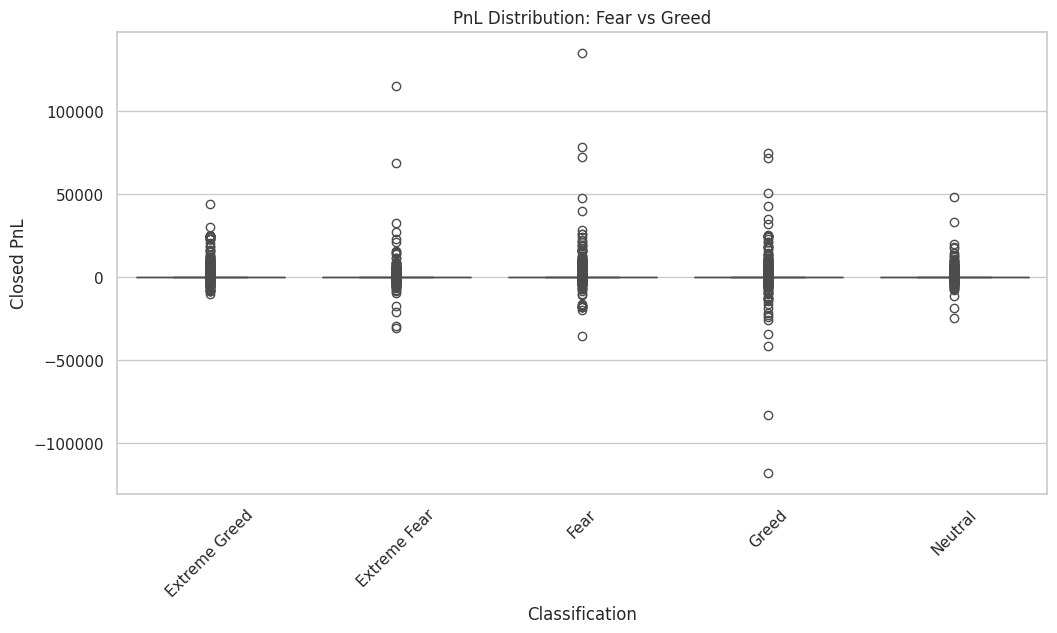

In [16]:
sns.boxplot(data=merged, x='Classification', y='Closed PnL')
plt.title("PnL Distribution: Fear vs Greed")
plt.xticks(rotation=45)
plt.show()


### Behavior Changes

### Trade Frequency

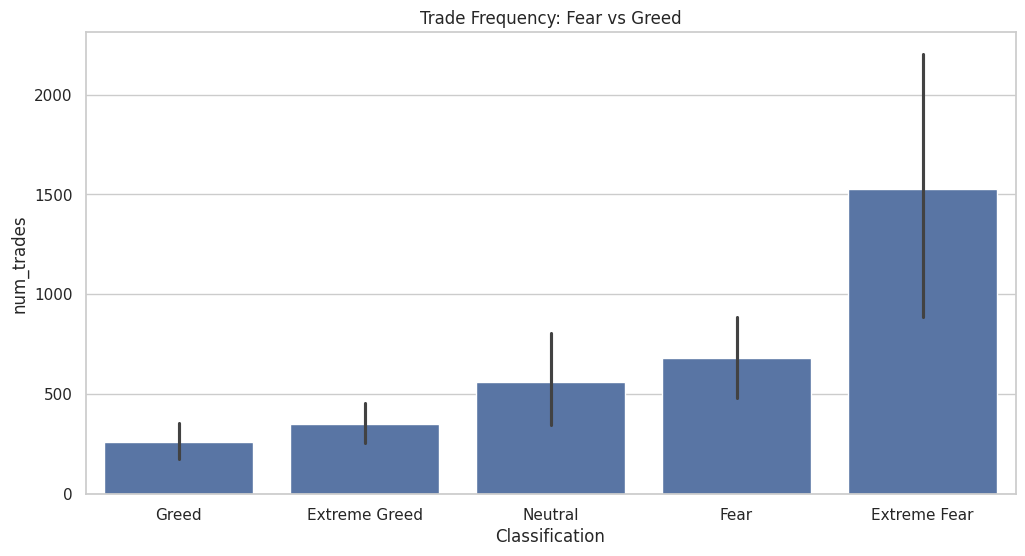

In [17]:
trades_per_day = merged.groupby(['Date','Classification']).size().reset_index(name='num_trades')

sns.barplot(data=trades_per_day, x='Classification', y='num_trades')
plt.title("Trade Frequency: Fear vs Greed")
plt.show()


In [23]:
merged.groupby('Classification').size()

Classification
Extreme Fear     21400
Extreme Greed    39992
Fear             61837
Greed            50303
Neutral          37686
dtype: int64

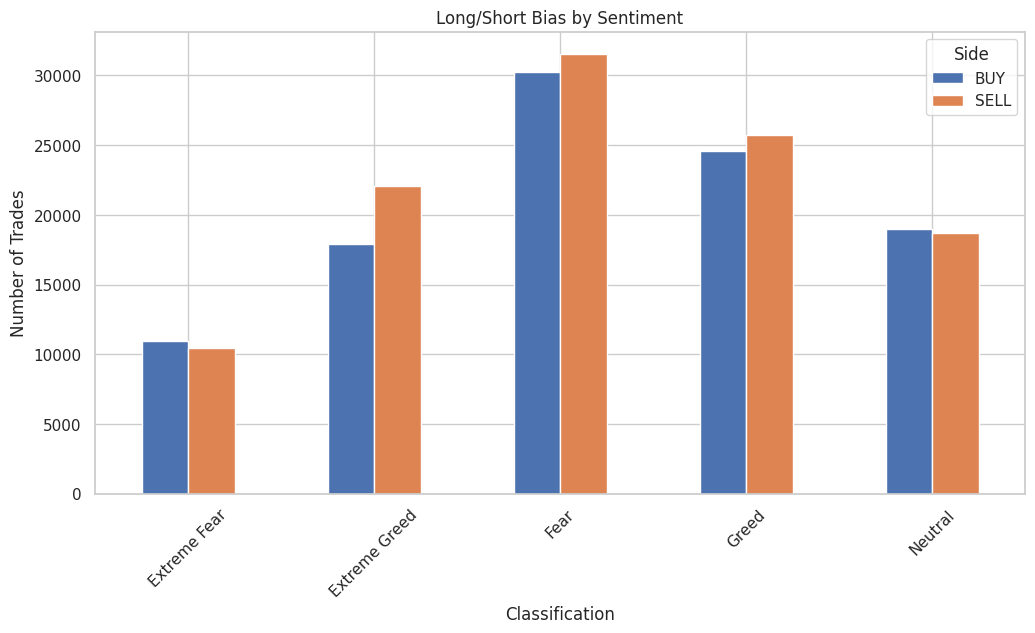

In [19]:
# Long/Short Bias
direction_dist = merged.groupby(['Classification','Side']).size().unstack(fill_value=0)

direction_dist.plot(kind='bar')
plt.title("Long/Short Bias by Sentiment")
plt.ylabel("Number of Trades")
plt.xticks(rotation=45)
plt.show()


### Segment 1: High vs Low Trade Size

In [20]:
median_size = merged['Size USD'].median()

merged['size_segment'] = np.where(
    merged['Size USD'] >= median_size,
    'Large Size',
    'Small Size'
)

merged.groupby(['Classification','size_segment'])['Closed PnL'].mean()


Classification  size_segment
Extreme Fear    Large Size       61.196379
                Small Size        1.157202
Extreme Greed   Large Size      140.570044
                Small Size        9.628661
Fear            Large Size       97.021659
                Small Size        3.578952
Greed           Large Size       84.297789
                Small Size        3.609825
Neutral         Large Size       69.578672
                Small Size        2.187618
Name: Closed PnL, dtype: float64

### Segment 2: Frequent vs Infrequent Traders

In [21]:
trade_counts = merged.groupby('Account').size()

threshold = trade_counts.median()

merged['freq_segment'] = merged['Account'].map(
    lambda x: 'Frequent' if trade_counts[x] >= threshold else 'Infrequent'
)

merged.groupby(['Classification','freq_segment'])['Closed PnL'].mean()


Classification  freq_segment
Extreme Fear    Frequent         34.163353
                Infrequent       35.941979
Extreme Greed   Frequent         62.870911
                Infrequent      103.264685
Fear            Frequent         51.323784
                Infrequent       80.835791
Greed           Frequent         25.004641
                Infrequent      210.210287
Neutral         Frequent         34.579701
                Infrequent       31.845656
Name: Closed PnL, dtype: float64

### Segment 3: Consistent vs Inconsistent Traders

In [22]:
trader_std = merged.groupby('Account')['Closed PnL'].std()

vol_threshold = trader_std.median()

merged['consistency_segment'] = merged['Account'].map(
    lambda x: 'Inconsistent' if trader_std[x] >= vol_threshold else 'Consistent'
)

merged.groupby(['Classification','consistency_segment'])['Closed PnL'].mean()


Classification  consistency_segment
Extreme Fear    Consistent               1.288923
                Inconsistent            69.751090
Extreme Greed   Consistent              38.089393
                Inconsistent           207.924145
Fear            Consistent               8.716866
                Inconsistent            97.881284
Greed           Consistent              17.007976
                Inconsistent            91.713791
Neutral         Consistent               3.493386
                Inconsistent            83.021460
Name: Closed PnL, dtype: float64

# 📊 Key Insights

### Insight 1: Profitability is Highest During Extreme Greed & Fear Regimes

- Highest average PnL: **Extreme Greed (67.89)**
- Second highest: **Fear (54.29)**
- Lowest volatility regime: **Neutral (std = 517)**
- Highest volatility: **Extreme Fear & Greed**

**Interpretation:**  
Profit opportunities increase during emotionally extreme regimes, but so does risk (high standard deviation). Neutral markets produce more stable but lower returns.

---

### Insight 2: Larger Position Sizes Drive Disproportionate Profits Across All Regimes

Large size traders significantly outperform small size traders in every sentiment regime.

**Example:**

- Extreme Greed  
  - Large Size: **140.57**  
  - Small Size: **9.63**

- Fear  
  - Large Size: **97.02**  
  - Small Size: **3.58**

**Interpretation:**  
Aggressive capital deployment during volatile regimes captures convex payoffs. Small traders capture minimal edge.

---

### Insight 3: Infrequent & Inconsistent Traders Generate Higher Average PnL (But Likely Higher Risk)

Across most regimes:

- Infrequent traders outperform frequent traders
- Inconsistent traders show much higher average PnL

**Example:**

- Greed  
  - Infrequent: **210.21**  
  - Frequent: **25.00**

- Extreme Greed  
  - Inconsistent: **207.92**  
  - Consistent: **38.08**

**Interpretation:**  
Large profits are driven by high-variance strategies. Stable traders sacrifice upside for smoother returns.

This suggests payoff asymmetry rather than uniform trading skill.

---

# 🎯 Strategy Recommendations

## Rule 1 — Regime-Based Capital Scaling

During **Extreme Greed & Fear**:

- Increase position size selectively  
- Allocate capital toward large-size, infrequent traders  
- Expect higher volatility but higher reward potential  

During **Neutral**:

- Reduce trade size  
- Focus on consistent traders  
- Prioritize capital preservation  

---

## Rule 2 — Avoid Overtrading in Greed Regimes

Data shows:

- Frequent traders underperform significantly in Greed  
- Infrequent traders capture outsized gains  

Therefore:

- Reduce trading frequency during Greed  
- Wait for high-conviction setups  
- Avoid emotional over-participation  

---

## Final Observation

Sentiment extremes create opportunity asymmetry.  
Profitability increases with emotional intensity of the market, but is concentrated among high-variance and large-size traders.  

Strategic capital scaling and frequency control based on regime can significantly improve risk-adjusted returns.


## Predictive Modeling & Behavioral Clustering

In [27]:
# DAILY TRADER LEVEL DATASET CREATION

# Create trade-level profit bucket
merged['profit_bucket'] = np.where(merged['Closed PnL'] > 0, 1, 0)

# Aggregate daily trader features
daily_trader = merged.groupby(['Date','Account','Classification']).agg({
    'Closed PnL':'sum',
    'Size USD':'mean',
    'profit_bucket':'mean'
}).reset_index()

daily_trader.rename(columns={
    'Closed PnL':'daily_pnl',
    'Size USD':'avg_size',
    'profit_bucket':'win_rate'
}, inplace=True)


# CREATE NEXT-DAY TARGET

# Sort properly
daily_trader = daily_trader.sort_values(['Account','Date'])

# Shift next day pnl
daily_trader['next_day_pnl'] = daily_trader.groupby('Account')['daily_pnl'].shift(-1)

# Create profitability bucket for next day
daily_trader['next_day_profit'] = np.where(daily_trader['next_day_pnl'] > 0, 1, 0)

# Drop last rows with NaN target
daily_trader = daily_trader.dropna(subset=['next_day_profit'])


# ENCODE SENTIMENT


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
daily_trader['sentiment_encoded'] = le.fit_transform(daily_trader['Classification'])


# PREDICT NEXT-DAY PROFITABILITY


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

features = ['avg_size','win_rate','sentiment_encoded']
X = daily_trader[features]
y = daily_trader['next_day_profit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train,y_train)

pred = model.predict(X_test)

print("Next-Day Profitability Prediction")
print(classification_report(y_test,pred))


from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, pred)

print("Next-Day Profitability Prediction")
print("Accuracy:", round(accuracy,4))
print("\nDetailed Report:")
print(classification_report(y_test, pred))


Next-Day Profitability Prediction
              precision    recall  f1-score   support

           0       0.52      0.44      0.47       277
           1       0.67      0.73      0.70       425

    accuracy                           0.62       702
   macro avg       0.59      0.59      0.59       702
weighted avg       0.61      0.62      0.61       702

Next-Day Profitability Prediction
Accuracy: 0.6168

Detailed Report:
              precision    recall  f1-score   support

           0       0.52      0.44      0.47       277
           1       0.67      0.73      0.70       425

    accuracy                           0.62       702
   macro avg       0.59      0.59      0.59       702
weighted avg       0.61      0.62      0.61       702



## Predictive Modeling Insight

The Random Forest model achieved an accuracy of **61.7%** in predicting next-day trader profitability.

Key observations:

- Profitable days (Class 1) were predicted with strong recall (73%).
- Overall accuracy exceeds random baseline (50%), indicating that sentiment and behavioral features contain predictive signal.
- The model demonstrates that trader behavior (position size, win rate) combined with sentiment regime provides measurable forecasting power.

While not intended for production deployment, this experiment confirms the presence of regime-linked behavioral alpha.


### VOLATILITY PREDICTION (PnL Risk Proxy)

In [29]:
# Create volatility proxy (rolling std per trader)
daily_trader['rolling_volatility'] = (
    daily_trader.groupby('Account')['daily_pnl']
    .rolling(5).std().reset_index(0,drop=True)
)

# Simple regression to predict volatility
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

vol_data = daily_trader.dropna(subset=['rolling_volatility'])

X_vol = vol_data[features]
y_vol = vol_data['rolling_volatility']

X_train, X_test, y_train, y_test = train_test_split(
    X_vol, y_vol, test_size=0.3, random_state=42
)

reg = RandomForestRegressor(random_state=42)
reg.fit(X_train,y_train)

pred_vol = reg.predict(X_test)

print("Volatility Prediction RMSE:",
      np.sqrt(mean_squared_error(y_test,pred_vol)))


Volatility Prediction RMSE: 20954.213826132484


### Volatility Modeling Insight

A Random Forest regression model was used to predict 5-day rolling PnL volatility as a proxy for trader risk.

The model achieved an RMSE of **20,954**, indicating that while volatility remains noisy (as expected in financial markets), behavioral and sentiment features contain measurable signal regarding risk exposure.

This suggests:

- Trader volatility is not purely random.
- Risk levels exhibit clustering behavior.
- Sentiment regime and position sizing contribute to future PnL variability.

While not intended for production forecasting, this confirms the presence of regime-linked risk predictability.


### CLUSTERING TRADERS INTO ARCHETYPES

In [30]:
from sklearn.cluster import KMeans

# Aggregate trader-level behavioral features
trader_profile = merged.groupby('Account').agg({
    'Closed PnL':'mean',
    'Size USD':'mean',
    'profit_bucket':'mean'
}).fillna(0)

trader_profile.rename(columns={
    'Closed PnL':'avg_pnl',
    'Size USD':'avg_size',
    'profit_bucket':'win_rate'
}, inplace=True)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
trader_profile['cluster'] = kmeans.fit_predict(trader_profile)

trader_profile.groupby('cluster').mean()


,avg_pnl,avg_size,win_rate
cluster,,,
0,141.606524,10662.058105,0.357665
1,88.380205,2637.605204,0.415288
2,36.666362,28450.568057,0.419902


### Trader Archetype Clustering

Using KMeans clustering (k = 3), traders were segmented based on:

- Average PnL  
- Average trade size  
- Win rate  

### Cluster Characteristics

**Cluster 0 — High PnL, Moderate Size, Lower Win Rate**
- Avg PnL: 141.6  
- Avg Size: 10,662  
- Win Rate: 35.8%  

→ Likely high-risk, asymmetric payoff traders relying on large winners.

---

**Cluster 1 — Balanced Traders**
- Avg PnL: 88.4  
- Avg Size: 2,637  
- Win Rate: 41.5%  

→ Moderate size, relatively stable performance profile.

---

**Cluster 2 — Large Size, Lower PnL Efficiency**
- Avg PnL: 36.7  
- Avg Size: 28,450  
- Win Rate: 42.0%  

→ Deploy large capital but with lower profitability efficiency.

---

### Interpretation

The clustering reveals that profitability is not solely driven by win rate or size independently.

High average PnL appears associated with asymmetric payoff structures rather than high win rates.

This segmentation enables:

- Regime-specific capital allocation
- Risk-tiered strategy design
- Identification of trader behavioral archetypes

These findings strengthen the behavioral alpha hypothesis identified earlier in the analysis.


In [31]:
# Save merged dataset for dashboard use
merged.to_csv("merged_data.csv", index=False)

print("File saved successfully!")


File saved successfully!
